In [3]:
import pandas as pd
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 15)
import sqlalchemy 
import tejapi
import numpy as np
from datetime import date,timedelta
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
import pandas_datareader.data as web
import datetime 
from arch import arch_model
import math

In [4]:
start = datetime .datetime(2005, 1, 1)
end = datetime .datetime(2022, 1, 1)
sp500 = web.DataReader('^GSPC', 'yahoo', start=start, end=end)
N225 = web.DataReader('^N225', 'yahoo', start=start, end=end)
gold = web.DataReader('GC=F', 'yahoo', start=start, end=end)
shanghai_index = web.DataReader('000001.SS', 'yahoo', start=start, end=end)
vanguardBond = web.DataReader('VBMFX', 'yahoo', start=start, end=end)
nasdaqIndex = web.DataReader('^IXIC', 'yahoo', start=start, end=end)

In [5]:
n225_pl = N225['Adj Close'].to_frame('Nikkei 225 Index').dropna()
gold_pl = gold['Adj Close'].to_frame('Gold').dropna()
shi_pl = shanghai_index['Adj Close'].to_frame('Shanghai Composite Index').dropna()
sp500_pl = sp500['Adj Close'].to_frame('S&P500 Index').dropna()
bond_pl = vanguardBond['Adj Close'].to_frame('Vanguard Bond Index Fund').dropna()
comm_pl = nasdaqIndex['Adj Close'].to_frame('Nasdaq Index').dropna()
portfolio_prices = sp500_pl.merge(n225_pl,right_index=True, left_index = True).merge(gold_pl,right_index=True, left_index = True).merge(shi_pl,right_index=True, left_index = True)
portfolio_prices = portfolio_prices.merge(bond_pl,right_index=True, left_index = True).merge(comm_pl,right_index=True, left_index = True)
summary_PnL = portfolio_prices.pct_change().dropna()
portfolio_prices.head(3)

,S&P500 Index,Nikkei 225 Index,Gold,Shanghai Composite Index,Vanguard Bond Index Fund,Nasdaq Index
Date,,,,,,
2005-01-04,1188.050049,11517.750000,428.500000,1242.774048,6.091893,2107.860107
2005-01-05,1183.739990,11437.519531,426.600006,1251.937012,6.091893,2091.239990
2005-01-06,1187.890015,11492.259766,421.000000,1239.430054,6.097839,2090.000000


In [6]:
summary_PnL = summary_PnL.reset_index().drop_duplicates(subset='Date', keep='last').set_index('Date').sort_index()
weights = np.array([.30,.30,.05,.10,.20,.05])

In [11]:
summary_PnL

,S&P500 Index,Nikkei 225 Index,Gold,Shanghai Composite Index,Vanguard Bond Index Fund,Nasdaq Index
Date,,,,,,
2005-01-05,-0.003628,-0.006966,-0.004434,0.007373,0.000000,-0.007885
2005-01-06,0.003506,0.004786,-0.013127,-0.009990,0.000976,-0.000593
2005-01-07,-0.001431,-0.005136,-0.004988,0.004289,-0.000975,-0.000665
2005-01-11,-0.002698,0.009337,0.007162,0.010216,0.001953,-0.004304
2005-01-12,0.003981,-0.007504,0.009955,-0.000429,0.000974,0.006208
...,...,...,...,...,...,...
2021-03-30,-0.003158,0.001640,-0.016471,0.006224,0.000000,-0.001092
2021-03-31,0.003622,-0.008626,0.017756,-0.004273,-0.000897,0.015445
2021-04-01,0.011825,0.007199,0.007410,0.007095,0.004488,0.017607


In [7]:
class ValueAtRisk:
    '''
        1. The the first code block calculate basic peformance indicators of each asset in the portfolio.
            Please fill in a dataframe of assets daily PnL and the the following fuctions will calculate performance for the given sample perriod.
    '''
    def __init__(self, daily_return, weights):
        self.daily_return = daily_return
        self.weights = weights
        self.cov_matrix = daily_return.cov()
        self.overview = self.portfolio_overview(daily_return)

    def performance_analysis(self,ret,asset):
        #Add marginal VaR
        riskfreerate=0.03
        days=250
        length = len(ret)
        rbar   = ret.mean()
        s      = ret.std()
        sharperatio   = np.sqrt(days)*(rbar - riskfreerate/days)/s
        cumuret = ((ret + 1)).cumprod()-1
        cumuret_per = cumuret*100
        nav = cumuret+1
        waterlevel = nav.cummax()
        drawdown = (waterlevel-nav)/waterlevel
        geomean = (1 + cumuret[-1:]) ** (1 / length)
        cumuretann = (geomean ** days - 1)*100
        duration = np.zeros_like(drawdown)
        for k in range(length - 1):
            if drawdown[k + 1] > 0:
                duration[k + 1] = duration[k] + 1
            else:
                duration[k + 1] = 0
        mdd = drawdown.max()*100
        mddd = duration.max()
        perf = pd.DataFrame()
        feature_idx = ['Number of observations:','Mean return (daily):','Standard deviation (daily):','Sharpe ratio (annualized):',
                     'Period return:','Geometric mean of 1+r:',
                     'Maximum drawdown:','Maximum drawdown duration:']
        pef_summary = [length,'%0.6f'%rbar,'%0.4f'%s,
                     '%0.4f'%sharperatio,'%0.2f'%cumuret_per[-1:]+'%','%0.6f'%geomean,
                     '%0.2f'%mdd+'%', '%d'%mddd+' days']
        perf['Asset/Performance'] = feature_idx
        perf[asset] = pef_summary
        return perf
    
    def portfolio_overview(self,df,period=250):
        df = df[-period:]
        cols = df.columns 
        feature_idx = ['Number of observations:','Mean return (daily):','Standard deviation (daily):','Sharpe ratio (annualized):',
                     'Period return:','Geometric mean of 1+r:',
                     'Maximum drawdown:','Maximum drawdown duration:']
        perf_table = pd.DataFrame()
        perf_table['Asset/Performance'] = feature_idx
        for col in cols:
            perf = self.performance_analysis(df[col],col)
            perf_table = perf_table.merge(perf,on='Asset/Performance')
            perf_table = perf_table.set_index('Asset/Performance')
        return perf_table.T

        
        '''
        2. This code block includes functions that apply different approaches of calculating VaR.
            Please input a dataframe of assets daily PnL and the the following fuctions will calculate VaR for the given sample perriod.
        '''
        
    def parametric(self, daily_return, weights):
        cov_matrix = daily_return.cov()
        date = daily_return.index.max()
        z1 = norm.ppf(5/100)
        z2 = norm.ppf(1/100)
        z3 = norm.ppf(2.5/100)
        daily_mean = np.average(daily_return, 1, weights)
        port_mean =daily_mean.mean()
        port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
        var_95 = port_mean + z1 * port_stdev 
        var_99 = port_mean + z2 * port_stdev 
        var_975 = port_mean + z3 * port_stdev 
        cvar_975 = np.mean(daily_mean[daily_mean < var_975])
        var_dict = {'VaR(95%)':var_95,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def historic(self,daily_return,weights):
        cov_matrix = daily_return.cov()
        date = daily_return.index.max()
        daily_return = np.average(daily_return, 1, weights)
        var_95 = np.percentile(daily_return,5)
        var_99 = np.percentile(daily_return,1)
        var_975 = np.percentile(daily_return,2.5)
        cvar_975 = np.mean(daily_return[daily_return < var_975])
        var_dict = {'VaR(95%)':var_95,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def monte_carlo(self, daily_return,weights):
        date = daily_return.index.max()
        mu = np.mean(np.average(daily_return, 1, weights))
        vol = np.std(np.average(daily_return, 1, weights))
        T = 250
        simulated_PnL = []
        for i in range(T):
            rand_rets = np.random.normal(mu, vol, 1000)
            simulated_PnL.append(rand_rets)
        var_95 = np.percentile(simulated_PnL,5)
        var_975 = np.percentile(simulated_PnL,2.5)
        var_99 = np.percentile(simulated_PnL,1)

        PnL_frame = pd.DataFrame(simulated_PnL)
        extrem_loss = PnL_frame[PnL_frame < var_975]
        #print(np.nanmean(extrem_loss))
        cvar_975 = np.nanmean(extrem_loss)

        var_dict = {'VaR(95%)':var_95,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975}
        df = pd.DataFrame(var_dict,index=[date])
        return df
    
    def garch(self,daily_return,weights):
        date = daily_return.index.max()
        weighted_avg = pd.DataFrame()
        weighted_avg['weighted_avg'] = np.average(daily_return, 1, weights) * 100
        am = arch_model(weighted_avg, vol='Garch', p=1, o=0 ,q=1, dist='skewt')
        res = am.fit(disp='off')
        forecasts = res.forecast()
        cond_mean = forecasts.mean
        cond_var = forecasts.variance
        q = am.distribution.ppf([0.05, 0.01, 0.025], res.params[-2:])
        value_at_risk = cond_mean.values + np.sqrt(cond_var).values * q[None, :]
        var_95 = value_at_risk[[-1,]][0][0]
        var_99 = value_at_risk[[-1,]][0][1]
        var_975 = value_at_risk[[-1,]][0][2]
        cvar_975 = np.mean(weighted_avg[weighted_avg['weighted_avg'] < var_975])
        if math.isnan(cvar_975):
            cvar_975 = [var_99]
        var_dict = {'VaR(95%)':var_95,'VaR(99%)':var_99,'Expected Shortfall(97.5%)':cvar_975[0]}
        df = pd.DataFrame(var_dict,index=[date])
        df = df / 100
        return df[-1:]
    
    def VaR_summary(self, df, weights, amount):
        summary = pd.DataFrame()
        summary = summary.append(self.parametric(df, weights)).append(self.historic(df, weights)).append(self.monte_carlo(df, weights)).append(self.garch(df, weights))
        idx = ['Parametric','Historical','Monte Carlo','GARCH']
        summary.index = idx
        summary.index.name = time.strftime("%Y-%m-%d")
        return summary * amount

        '''
        3. This code block defines function to generate data for backtest.
        '''
        
    def backtest_data(self, daily_return, weights, method, window_days=250):
        start_time = time.time()
        method_map = {'Parametric':self.parametric,'Historical':self.historic,'MonteCarlo':self.monte_carlo,'GARCH':self.garch}
        method_applied = method_map[method]        
        weighted_daily_PnL = pd.DataFrame(np.average(daily_return, 1, weights),index = daily_return.index, columns = ['Daily PnL'])
        daily_VaR_table = pd.DataFrame()
        for i in range(len(daily_return)-window_days):
            daily_PL = daily_return[i:i+window_days]
            date = daily_PL.index.max()
            daily_VaR = method_applied(daily_PL,weights)
            daily_VaR_table = daily_VaR_table.append(daily_VaR)

        daily_VaR_table.index = daily_VaR_table.index + pd.DateOffset(1)
        df = pd.merge_asof(weighted_daily_PnL,daily_VaR_table, right_index = True, left_index = True)
        df['VaR(95%) exception'] = np.where((df['VaR(99%)'] < df['Daily PnL']) & (df['Daily PnL'] < df['VaR(95%)']),'True','False')
        df['VaR(99%) exception'] = np.where(df['Daily PnL'] < df['VaR(99%)'],'True','False')  
        df = df.dropna()
        print(method+':',"--- %s seconds ---" % (time.time() - start_time))
        return df           
    
    def backtest_plot(self, VaR_table, model_name, begin_date='2007-01-01', end_date='2021-06-01'):
        VaR_table = VaR_table[begin_date:end_date]
        #Check dates where there is a VaR exception
        VaR_table['VaR(95%) exception'] = np.where((VaR_table['VaR(99%)'] < VaR_table['Daily PnL']) & (VaR_table['Daily PnL'] < VaR_table['VaR(95%)']),'True','False')
        VaR_table['VaR(99%) exception'] = np.where(VaR_table['Daily PnL'] < VaR_table['VaR(99%)'],'True','False')  
        
        obs = len(VaR_table)
        fig,ax = plt.subplots(1,1,figsize=(16,10))
        normal_PnL = VaR_table[(VaR_table['VaR(95%) exception']=='False') & (VaR_table['VaR(99%) exception']=='False')]['Daily PnL']
        #ax.scatter(normal_PnL.index,normal_PnL,color = '#1ba1e2',alpha=0.5)
        ax.plot(VaR_table['Daily PnL'], color = '#1ba1e2')
        ax.plot(VaR_table['VaR(95%)'], color = '#fa6800', alpha = 0.7)
        ax.plot(VaR_table['VaR(99%)'], color = '#e51400', alpha = 0.7)
        #ax.plot(VaR_table[['CVaR(95%)']])
        exceed_95 = VaR_table[VaR_table['VaR(95%) exception']=='True']['Daily PnL']
        exceed_99 = VaR_table[VaR_table['VaR(99%) exception']=='True']['Daily PnL']
        count_95 = (exceed_95.count() + exceed_99.count()) / obs
        count_99 = exceed_99.count() / obs

        r = VaR_table.index

        text_to_show ='Number of observations: ' + str(obs) + '\nVaR(95%) exceptions: ' + str(exceed_95.count() + exceed_99.count()) + '\nVaR(99%) exceptions: ' + str(exceed_99.count())
        ax.text(r[-(round(obs/4))], VaR_table['Daily PnL'].max()*.9, text_to_show,size=12)

        ax.scatter(exceed_95.index,exceed_95,marker='s',  facecolors='none', edgecolors='#BB00BB', s = 120) #'#BB00BB'
        ax.scatter(exceed_99.index,exceed_99,marker='x',  facecolors='#a20025', s = 120) ##a20025
        ax.spines['bottom'].set_color('#b0abab')
        ax.spines['top'].set_color('#b0abab')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(linestyle='--', alpha=0.5)
        ax.legend(['Daily PnL','VaR(95%)','VaR(99%)','VaR(95%), exception rates: ' + str(round(count_95*100,2))+'%',
                    'VaR(99%), exception rates: ' + str(round(count_99*100,2))+'%'],loc='upper left',prop={'size': 12})
        ax.set_title(model_name + ' VaR Backtest', fontsize=16, fontweight=1)
        plt.show()

In [8]:
VaR = ValueAtRisk(summary_PnL,weights)

In [9]:
VaR.overview

Asset/Performance,Number of observations:,Mean return (daily):,Standard deviation (daily):,Sharpe ratio (annualized):,Period return:,Geometric mean of 1+r:,Maximum drawdown:,Maximum drawdown duration:
S&P500 Index,250,0.001057,0.0224,0.6605,22.24%,1.000803,28.52%,57 days
Nikkei 225 Index,250,0.001104,0.0170,0.9144,27.13%,1.000961,26.77%,61 days
Gold,250,0.000335,0.0148,0.2298,5.81%,1.000226,18.22%,146 days
Shanghai Composite Index,250,0.000622,0.0128,0.6201,14.47%,1.000541,13.40%,73 days
Vanguard Bond Index Fund,250,0.000051,0.0034,-0.3216,1.13%,1.000045,6.53%,146 days
Nasdaq Index,250,0.001704,0.0233,1.0730,42.94%,1.001430,23.92%,48 days


In [10]:
VaR.VaR_summary(summary_PnL[:],weights, 1000000).style.format('{:,.0f}')

,VaR(95%),VaR(99%),Expected Shortfall(97.5%)
2021-04-08,,,
Parametric,"-12,564","-17,925","-25,091"
Historical,"-10,974","-23,244","-24,978"
Monte Carlo,"-12,553","-17,925","-17,994"
GARCH,"-9,802","-16,724","-21,625"


In [9]:
#Backtest of 12 years data
para_var = VaR.backtest_data(summary_PnL, weights, 'Parametric')
hist_var = VaR.backtest_data(summary_PnL, weights, 'Historical')
mcvar = VaR.backtest_data(summary_PnL, weights, 'MonteCarlo')
garch_var = VaR.backtest_data(summary_PnL, weights, 'GARCH')

Parametric: --- 11.180949449539185 seconds ---
Historical: --- 8.682756900787354 seconds ---
MonteCarlo: --- 582.0744802951813 seconds ---
GARCH: --- 236.38688492774963 seconds ---


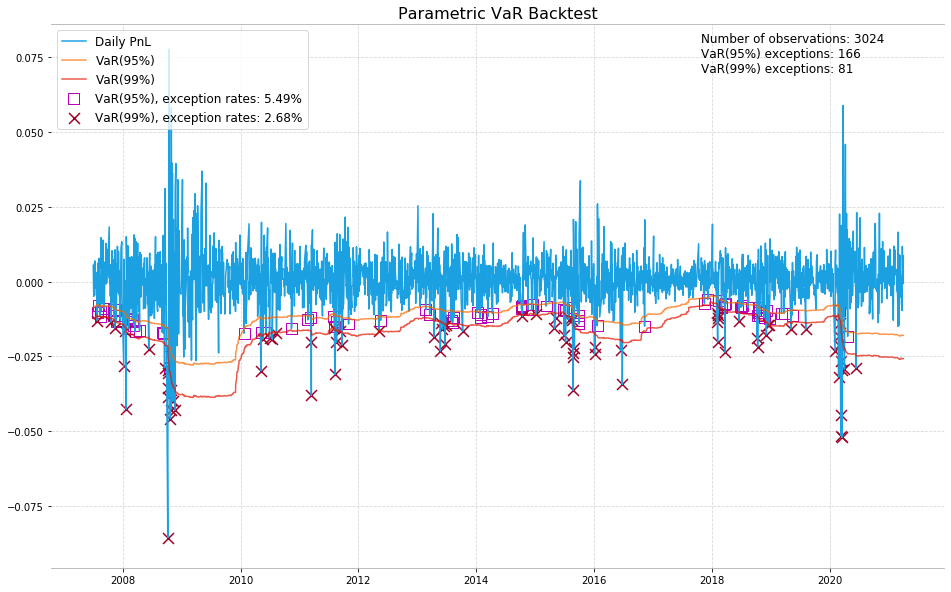

In [10]:
VaR.backtest_plot(para_var, 'Parametric', begin_date='2007-07-01', end_date='2021-06-01')

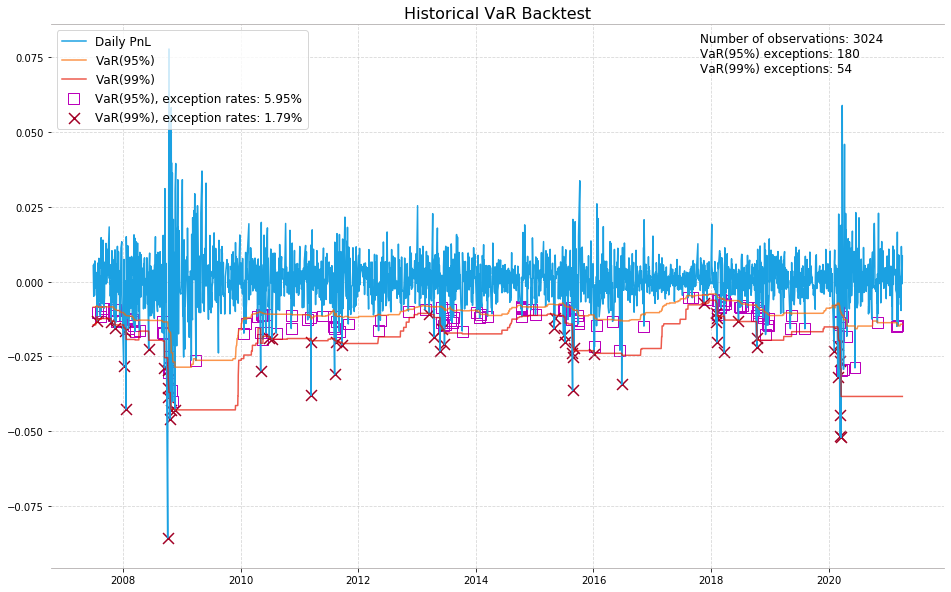

In [11]:
VaR.backtest_plot(hist_var, 'Historical', begin_date='2007-07-01', end_date='2021-06-01')

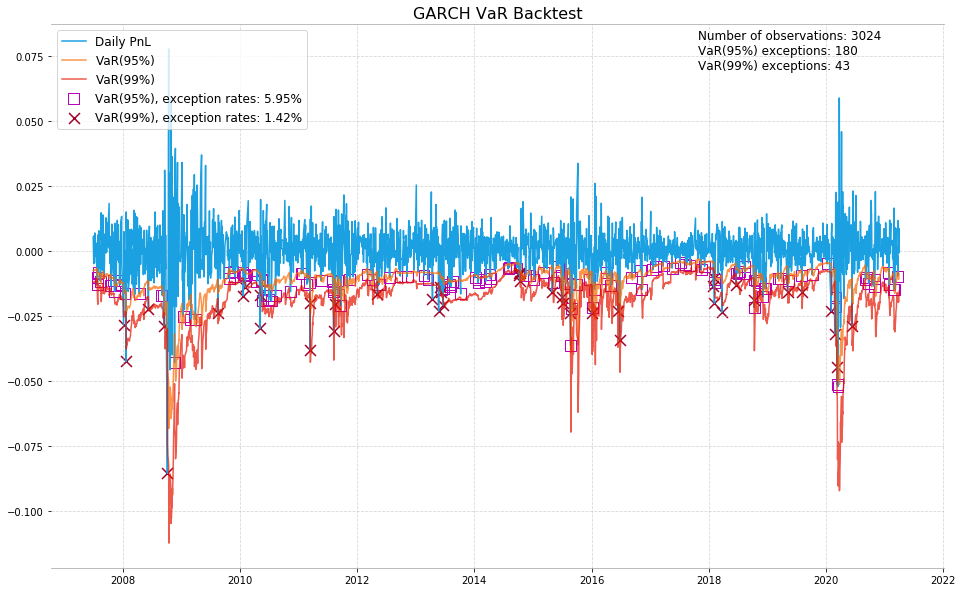

In [12]:
VaR.backtest_plot(garch_var, 'GARCH', begin_date='2007-07-01', end_date='2021-06-01')

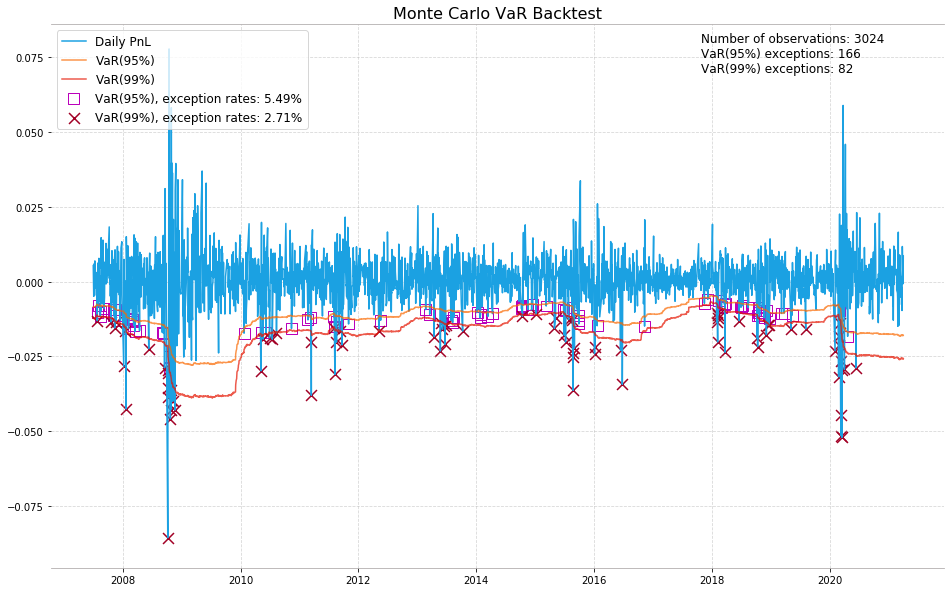

In [13]:
VaR.backtest_plot(mcvar, 'Monte Carlo', begin_date='2007-07-01', end_date='2021-06-01')